In [3]:
# Import all required libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

# LightGBM import
import lightgbm as lgb

# External libraries
from ucimlrepo import fetch_ucirepo
import optuna
from optuna.samplers import TPESampler
import shap

# Configuration
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [4]:
# Load Adult Income Dataset from UCI
adult = fetch_ucirepo(id=2)

X = adult.data.features
y = adult.data.targets

# Combine features and targets
df = pd.concat([X, y], axis=1)

print("DATASET LOADED")
print("=" * 50)
print(f"Dataset Shape: {df.shape}")
print(f"Features: {df.shape[1]-1} (Numerical: 6, Categorical: 8)")
print(f"Target: income (binary classification)")
print("\nCategorical Variables:")
print(X.select_dtypes(include=['object']).columns.tolist())
print("=" * 50)
print("\nFirst 5 rows:")
print(df.head(5))

DATASET LOADED
Dataset Shape: (48842, 15)
Features: 14 (Numerical: 6, Categorical: 8)
Target: income (binary classification)

Categorical Variables:
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

First 5 rows:
   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Bl

# Adult Income Dataset Variable Description

This dataset is extracted from the 1994 United States Census Bureau database for adult income prediction.

## Dataset Overview
- **Total Samples**: 48,842
- **Features**: 14 (6 numerical, 8 categorical)
- **Target**: income (binary classification)

## Numerical Variables (6)

| Variable | Description | Notes |
|----------|-------------|-------|
| **age** | Age | Continuous variable |
| **fnlwgt** | Final weight | Census weight (sample representativeness) |
| **education-num** | Education years | Numerical representation of education level |
| **capital-gain** | Capital gains | Investment returns, etc. |
| **capital-loss** | Capital loss | Investment losses, etc. |
| **hours-per-week** | Hours per week | Continuous variable |

## Categorical Variables (8)

| Variable | Description | Missing Values | Example Values |
|----------|-------------|----------------|----------------|
| **workclass** | Employment type | 963 | Private, Self-emp-not-inc, State-gov, etc. |
| **education** | Education level | 0 | Bachelors, HS-grad, 11th, Masters, etc. |
| **marital-status** | Marital status | 0 | Never-married, Married-civ-spouse, Divorced, etc. |
| **occupation** | Occupation | 966 | Adm-clerical, Exec-managerial, Prof-specialty, etc. |
| **relationship** | Family relationship | 0 | Not-in-family, Husband, Wife, Own-child, etc. |
| **race** | Race | 0 | White, Black, Asian-Pac-Islander, etc. |
| **sex** | Gender | 0 | Male, Female |
| **native-country** | Birth country | 274 | United-States, Cuba, Jamaica, etc. |

## Target Variable

| Variable | Description | Classes |
|----------|-------------|---------|
| **income** | Annual income | <=50K (approx. 76%), >50K (approx. 24%) |

In [5]:
# Target Variable Processing
print("TARGET VARIABLE PROCESSING")
print("=" * 50)
print("Original target distribution:")
print(y.value_counts())

# Remove periods and convert to binary classification
y_cleaned = y['income'].str.rstrip('.')
y_binary = (y_cleaned == '>50K').astype(int)

print("\nBinary classification after conversion:")
print(y_binary.value_counts())
print(f"Class distribution: {y_binary.value_counts(normalize=True).round(3).to_dict()}")

# Apply processed target to dataframe
df['income'] = y_binary

# Set final X, y variables
X_final = df.drop('income', axis=1)
y_final = df['income']

print("\nFINAL DATASET STRUCTURE")
print("-" * 30)
print(f"Features (X): {X_final.shape}")
print(f"Target (y): {y_final.shape}")
print(f"Class 0 (<=50K): {(y_final == 0).sum()} samples ({(y_final == 0).mean():.1%})")
print(f"Class 1 (>50K): {(y_final == 1).sum()} samples ({(y_final == 1).mean():.1%})")
print("=" * 50)

TARGET VARIABLE PROCESSING
Original target distribution:
income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64

Binary classification after conversion:
income
0    37155
1    11687
Name: count, dtype: int64
Class distribution: {0: 0.761, 1: 0.239}

FINAL DATASET STRUCTURE
------------------------------
Features (X): (48842, 14)
Target (y): (48842,)
Class 0 (<=50K): 37155 samples (76.1%)
Class 1 (>50K): 11687 samples (23.9%)


In [6]:
# Variable Unique Values Analysis
print("VARIABLE UNIQUE VALUES ANALYSIS")
print("=" * 50)

for col in X_final.columns:
    unique_vals = X_final[col].nunique()
    print(f"{col:20} : {unique_vals:3d} unique values")
    if unique_vals < 10:
        print(f"{'':20}   Values: {X_final[col].unique()}")
    print()

print("=" * 50)

VARIABLE UNIQUE VALUES ANALYSIS
age                  :  74 unique values

workclass            :   9 unique values
                       Values: ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked' nan]

fnlwgt               : 28523 unique values

education            :  16 unique values

education-num        :  16 unique values

marital-status       :   7 unique values
                       Values: ['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']

occupation           :  15 unique values

relationship         :   6 unique values
                       Values: ['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative']

race                 :   5 unique values
                       Values: ['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']

sex                  :   2 unique values
                       Values: ['Male' '

In [7]:
# Missing Values Analysis
print("MISSING VALUES ANALYSIS")
print("=" * 80)

# 1. Identify variables with missing values
missing_cols = ['workclass', 'occupation', 'native-country']

# 2. Individual variable analysis
print("VARIABLE-WISE MISSING VALUES ANALYSIS")
print("-" * 50)

for col in missing_cols:
    print(f"\n[{col.upper()}]")
    
    # Missing value count and ratio
    missing_count = df[col].isnull().sum()
    missing_ratio = (missing_count / len(df)) * 100
    print(f"Missing values: {missing_count} ({missing_ratio:.2f}%)")
    
    # Valid values analysis
    valid_values = df[col].dropna()
    unique_count = valid_values.nunique()
    print(f"Unique values: {unique_count}")
    
    # Mode analysis
    value_counts = valid_values.value_counts()
    top_value = value_counts.iloc[0]
    top_value_name = value_counts.index[0]
    top_ratio = (top_value / len(valid_values)) * 100
    
    print(f"Mode: '{top_value_name}' ({top_value} values, {top_ratio:.1f}%)")
    
    # Top 5 values distribution
    print("Top 5 value distribution:")
    for i, (val, count) in enumerate(value_counts.head(5).items()):
        ratio = (count / len(valid_values)) * 100
        print(f"  {i+1}. {val}: {count} ({ratio:.1f}%)")

# 3. Target distribution analysis for missing values
print("\n" + "=" * 80)
print("TARGET DISTRIBUTION ANALYSIS FOR MISSING VALUES")
print("-" * 50)

missing_mask = df[missing_cols].isnull().any(axis=1)
missing_rows = df[missing_mask]
non_missing_rows = df[~missing_mask]

print(f"Rows with missing values: {len(missing_rows)}")
print(f"Rows without missing values: {len(non_missing_rows)}")

# Overall income distribution
total_income_dist = df['income'].value_counts(normalize=True)
print("\nOverall income distribution:")
for val, ratio in total_income_dist.items():
    print(f"  Class {val}: {ratio:.3f} ({ratio*100:.1f}%)")

# Missing rows income distribution
missing_income_dist = missing_rows['income'].value_counts(normalize=True)
print("\nIncome distribution for rows with missing values:")
for val, ratio in missing_income_dist.items():
    print(f"  Class {val}: {ratio:.3f} ({ratio*100:.1f}%)")

# 4. Variable-specific missing value impact
print("\n" + "-" * 50)
print("VARIABLE-SPECIFIC MISSING VALUE IMPACT")

for col in missing_cols:
    print(f"\n[{col.upper()}] Missing Value Impact:")
    
    col_missing_mask = df[col].isnull()
    col_missing_rows = df[col_missing_mask]
    
    if len(col_missing_rows) > 0:
        col_missing_income_dist = col_missing_rows['income'].value_counts(normalize=True)
        
        print(f"Missing rows: {len(col_missing_rows)}")
        for val, ratio in col_missing_income_dist.items():
            print(f"  Class {val}: {ratio:.3f} ({ratio*100:.1f}%)")
        
        # Difference from overall distribution
        print("Difference from overall distribution:")
        for val in [0, 1]:
            total_ratio = total_income_dist[val]
            col_missing_ratio = col_missing_income_dist.get(val, 0)
            diff = abs(total_ratio - col_missing_ratio)
            print(f"  Class {val}: {diff:.3f} ({diff*100:.1f}%p)")

# 5. Treatment recommendation
print("\n" + "=" * 80)
print("MISSING VALUE TREATMENT STRATEGY")
print("-" * 50)

print("Treatment decision criteria:")

for col in missing_cols:
    print(f"\n[{col.upper()}]:")
    
    # Mode ratio check
    valid_values = df[col].dropna()
    value_counts = valid_values.value_counts()
    top_ratio = (value_counts.iloc[0] / len(valid_values)) * 100
    
    if top_ratio >= 50:
        print(f"  Mode '{value_counts.index[0]}' accounts for {top_ratio:.1f}% (majority)")
        print(f"  RECOMMENDATION: Replace with mode")
    else:
        print(f"  Mode ratio is {top_ratio:.1f}% (low)")
        print(f"  RECOMMENDATION: Create 'Unknown' category or delete rows")

# 6. Final recommendations
print(f"\nFINAL RECOMMENDATIONS:")

# Check if missing rows have similar target distribution
max_diff = max([abs(total_income_dist[val] - missing_income_dist.get(val, 0)) for val in [0, 1]])

if max_diff <= 0.05:  # Within 5% difference
    print("Target distribution in missing rows is similar to overall")
    print("SAFE to delete missing rows")
else:
    print("Target distribution in missing rows differs from overall")
    print("Deleting rows may introduce bias")

print(f"\nMissing ratio: {(len(missing_rows)/len(df)*100):.1f}%")
if len(missing_rows)/len(df) <= 0.05:  # Within 5%
    print("Low missing ratio - safe to delete")
else:
    print("High missing ratio - significant data loss if deleted")

print("=" * 80)

MISSING VALUES ANALYSIS
VARIABLE-WISE MISSING VALUES ANALYSIS
--------------------------------------------------

[WORKCLASS]
Missing values: 963 (1.97%)
Unique values: 9
Mode: 'Private' (33906 values, 70.8%)
Top 5 value distribution:
  1. Private: 33906 (70.8%)
  2. Self-emp-not-inc: 3862 (8.1%)
  3. Local-gov: 3136 (6.5%)
  4. State-gov: 1981 (4.1%)
  5. ?: 1836 (3.8%)

[OCCUPATION]
Missing values: 966 (1.98%)
Unique values: 15
Mode: 'Prof-specialty' (6172 values, 12.9%)
Top 5 value distribution:
  1. Prof-specialty: 6172 (12.9%)
  2. Craft-repair: 6112 (12.8%)
  3. Exec-managerial: 6086 (12.7%)
  4. Adm-clerical: 5611 (11.7%)
  5. Sales: 5504 (11.5%)

[NATIVE-COUNTRY]
Missing values: 274 (0.56%)
Unique values: 42
Mode: 'United-States' (43832 values, 90.2%)
Top 5 value distribution:
  1. United-States: 43832 (90.2%)
  2. Mexico: 951 (2.0%)
  3. ?: 583 (1.2%)
  4. Philippines: 295 (0.6%)
  5. Germany: 206 (0.4%)

TARGET DISTRIBUTION ANALYSIS FOR MISSING VALUES
------------------------

# Missing Value Treatment Strategy and Decision Process

## Missing Value Analysis Summary

### Missing Value Status
- **workclass**: 963 values (1.97%)
- **occupation**: 966 values (1.98%) 
- **native-country**: 274 values (0.56%)

## Missing Value Treatment Decision Process

### 1. Target Variable Distribution Impact Analysis
Compare income distribution of rows with missing values against overall distribution to check for bias

### 2. Mode Replacement Feasibility Assessment
Check mode ratio for each variable to determine appropriateness of mode replacement
- Over 50%: Consider mode replacement
- Under 50%: Consider creating Unknown category or row deletion

### 3. Data Loss vs Bias Trade-off Consideration
Comprehensively consider missing value ratio and target distribution differences

## Final Missing Value Treatment Strategy

| Variable | Treatment Method | Rationale |
|----------|------------------|-----------|
| **workclass** | Mode replacement ('Private') | Mode accounts for 70.8% (majority)<br>Target distribution difference exists but replacement acceptable |
| **occupation** | Create 'Unknown' category | Low mode ratio<br>Target distribution difference exists |
| **native-country** | Delete rows with missing values | Low missing ratio (0.56%)<br>Minimal target distribution difference |

In [8]:
# Missing Values Treatment Implementation
print("MISSING VALUES TREATMENT IMPLEMENTATION")
print("=" * 60)

print("BEFORE TREATMENT:")
print(f"Total dataset size: {df.shape}")
print("Missing values status:")
for col in ['workclass', 'occupation', 'native-country']:
    missing_count = df[col].isnull().sum()
    print(f"  {col:15}: {missing_count:3d} missing values")

# Create backup copy
df_processed = df.copy()

print(f"\nSTEP 1: Remove rows with missing native-country")
print("-" * 30)
# 1. Remove rows with missing native-country
before_count = len(df_processed)
df_processed = df_processed.dropna(subset=['native-country'])
after_count = len(df_processed)
deleted_rows = before_count - after_count

print(f"Deleted rows: {deleted_rows}")
print(f"Remaining dataset size: {df_processed.shape}")

print(f"\nSTEP 2: Replace workclass with mode")
print("-" * 30)
# 2. Replace workclass missing values with mode
workclass_mode = df_processed['workclass'].mode()[0]  # Mode
workclass_missing_before = df_processed['workclass'].isnull().sum()

df_processed['workclass'] = df_processed['workclass'].fillna(workclass_mode)
workclass_missing_after = df_processed['workclass'].isnull().sum()

print(f"Mode value: '{workclass_mode}'")
print(f"Replaced missing values: {workclass_missing_before} -> {workclass_missing_after}")

print(f"\nSTEP 3: Replace occupation with 'Unknown' category")
print("-" * 30)
# 3. Replace occupation missing values with 'Unknown' category
occupation_missing_before = df_processed['occupation'].isnull().sum()

df_processed['occupation'] = df_processed['occupation'].fillna('Unknown')
occupation_missing_after = df_processed['occupation'].isnull().sum()

print(f"Replaced missing values: {occupation_missing_before} -> {occupation_missing_after}")

print(f"\n" + "=" * 60)
print("TREATMENT COMPLETED")
print(f"Final dataset size: {df_processed.shape}")
print("Final missing values status:")
missing_final = df_processed.isnull().sum()
missing_final = missing_final[missing_final > 0]
if len(missing_final) == 0:
    print("  No missing values remaining")
else:
    print(missing_final)

# Check processed data target distribution
print(f"\nTARGET DISTRIBUTION AFTER TREATMENT:")
final_income_dist = df_processed['income'].value_counts(normalize=True)
print("Final income distribution:")
for val, ratio in final_income_dist.items():
    print(f"  Class {val}: {ratio:.3f} ({ratio*100:.1f}%)")

# Update final X, y variables
X_final = df_processed.drop('income', axis=1)
y_final = df_processed['income']

print(f"\nFINAL DATASET SUMMARY:")
print("-" * 30)
print(f"Features (X): {X_final.shape}")
print(f"Target (y): {y_final.shape}")
print(f"Total removed rows: {len(df) - len(df_processed)}")
print(f"Removal rate: {((len(df) - len(df_processed))/len(df)*100):.2f}%")

print("=" * 60)

MISSING VALUES TREATMENT IMPLEMENTATION
BEFORE TREATMENT:
Total dataset size: (48842, 15)
Missing values status:
  workclass      : 963 missing values
  occupation     : 966 missing values
  native-country : 274 missing values

STEP 1: Remove rows with missing native-country
------------------------------
Deleted rows: 274
Remaining dataset size: (48568, 15)

STEP 2: Replace workclass with mode
------------------------------
Mode value: 'Private'
Replaced missing values: 944 -> 0

STEP 3: Replace occupation with 'Unknown' category
------------------------------
Replaced missing values: 947 -> 0

TREATMENT COMPLETED
Final dataset size: (48568, 15)
Final missing values status:
  No missing values remaining

TARGET DISTRIBUTION AFTER TREATMENT:
Final income distribution:
  Class 0: 0.761 (76.1%)
  Class 1: 0.239 (23.9%)

FINAL DATASET SUMMARY:
------------------------------
Features (X): (48568, 14)
Target (y): (48568,)
Total removed rows: 274
Removal rate: 0.56%


In [9]:
# Numerical Variables Preprocessing Analysis
print("NUMERICAL VARIABLES PREPROCESSING ANALYSIS")
print("=" * 60)

numerical_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

# Basic statistics and scale differences
print("STATISTICS AND SCALE DIFFERENCES:")
print("-" * 40)
ranges = {}
for col in numerical_cols:
    data = df_processed[col]
    range_val = data.max() - data.min()
    ranges[col] = range_val
    zero_ratio = (data == 0).mean()
    
    print(f"{col:20}: Range {data.min():8.0f} - {data.max():8.0f} | Zero ratio: {zero_ratio:5.1%}")

print("=" * 60)

NUMERICAL VARIABLES PREPROCESSING ANALYSIS
STATISTICS AND SCALE DIFFERENCES:
----------------------------------------
age                 : Range       17 -       90 | Zero ratio:  0.0%
fnlwgt              : Range    12285 -  1490400 | Zero ratio:  0.0%
education-num       : Range        1 -       16 | Zero ratio:  0.0%
capital-gain        : Range        0 -    99999 | Zero ratio: 91.7%
capital-loss        : Range        0 -     4356 | Zero ratio: 95.3%
hours-per-week      : Range        1 -       99 | Zero ratio:  0.0%


NUMERICAL VARIABLES DISTRIBUTION VISUALIZATION


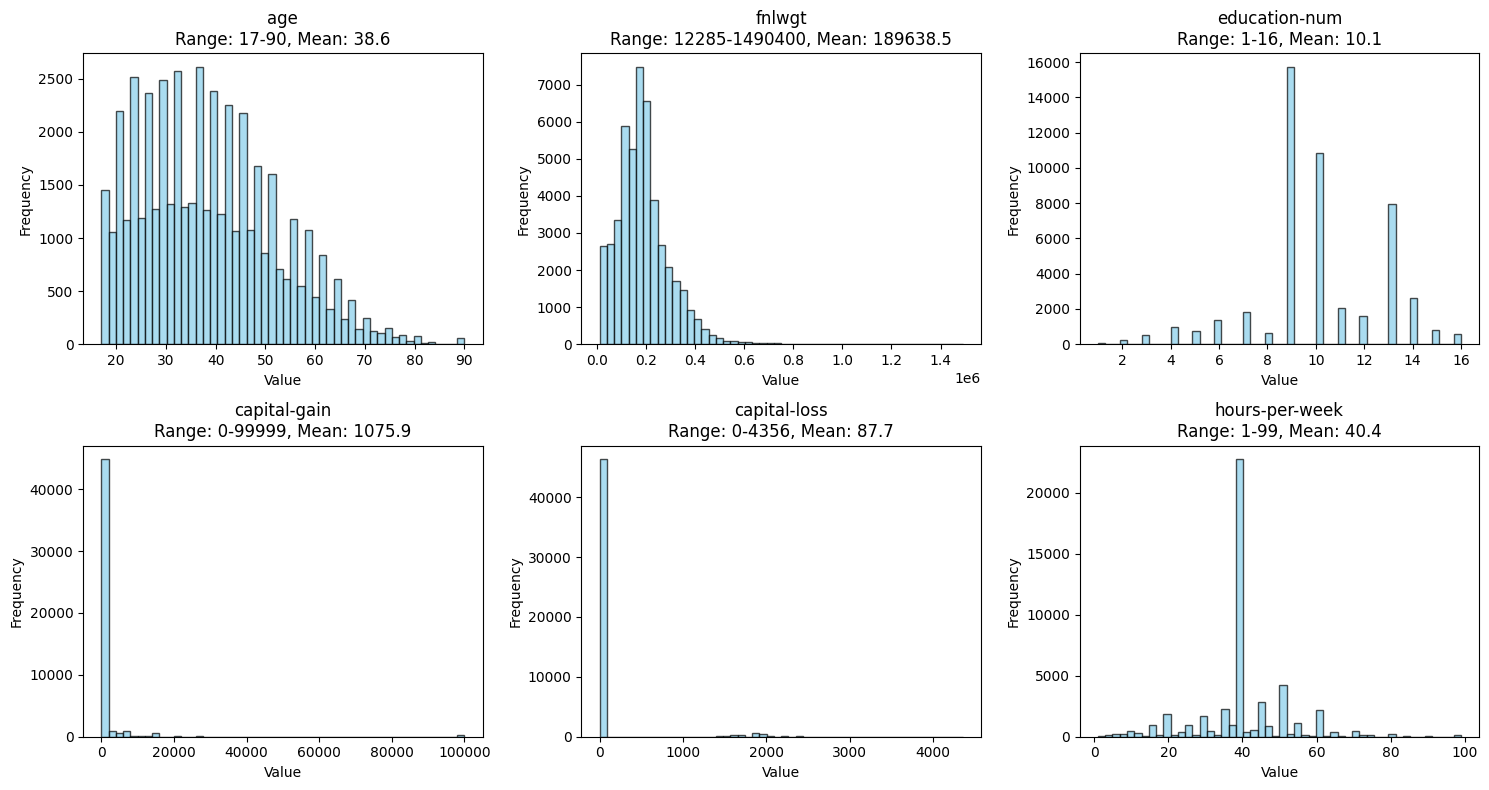

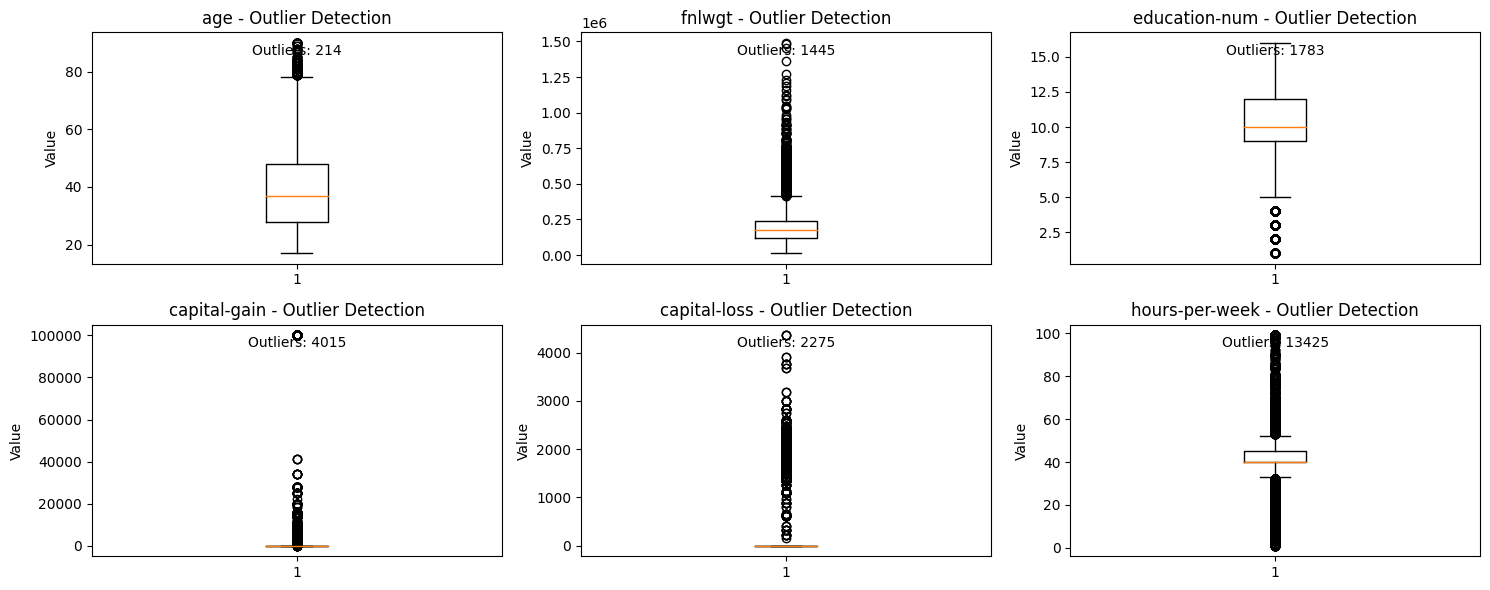

VISUALIZATION COMPLETED
Histograms: Distribution analysis
Boxplots: Outlier detection


In [10]:
# Numerical Variables Distribution Visualization
print("NUMERICAL VARIABLES DISTRIBUTION VISUALIZATION")
print("=" * 60)

# Distribution plots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    data = df_processed[col]
    
    # Histogram
    axes[i].hist(data, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
    axes[i].set_title(f'{col}\nRange: {data.min()}-{data.max()}, Mean: {data.mean():.1f}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Boxplot for outlier detection
fig, axes = plt.subplots(2, 3, figsize=(15, 6))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    data = df_processed[col]
    
    # Boxplot
    axes[i].boxplot(data)
    axes[i].set_title(f'{col} - Outlier Detection')
    axes[i].set_ylabel('Value')
    
    # Outlier count
    Q1, Q3 = data.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    outlier_count = ((data < Q1-1.5*IQR) | (data > Q3+1.5*IQR)).sum()
    axes[i].text(0.5, 0.95, f'Outliers: {outlier_count}', 
                transform=axes[i].transAxes, ha='center', va='top')

plt.tight_layout()
plt.show()

print("VISUALIZATION COMPLETED")
print("Histograms: Distribution analysis")
print("Boxplots: Outlier detection")
print("=" * 60)

In [11]:
# Final Data Preprocessing Implementation
print("FINAL DATA PREPROCESSING IMPLEMENTATION")
print("=" * 60)

# 1. Categorical variables encoding
print("STEP 1: CATEGORICAL VARIABLES ENCODING")
print("-" * 40)
X_processed = df_processed.drop('income', axis=1).copy()
y_processed = df_processed['income'].copy()

categorical_columns = X_processed.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    X_processed[col] = le.fit_transform(X_processed[col].astype(str))
    label_encoders[col] = le
    print(f"{col:20}: {len(le.classes_):3d} classes")

# 2. Log transformation for skewed variables
print(f"\nSTEP 2: LOG TRANSFORMATION")
print("-" * 40)
print("Applying log1p transformation to skewed variables:")
print("- capital-gain -> capital-gain-log")
print("- capital-loss -> capital-loss-log")

X_processed['capital-gain-log'] = np.log1p(X_processed['capital-gain'])
X_processed['capital-loss-log'] = np.log1p(X_processed['capital-loss'])

# Remove original columns
X_processed = X_processed.drop(['capital-gain', 'capital-loss'], axis=1)

print(f"\nFINAL PREPROCESSING SUMMARY")
print("-" * 40)
print(f"Features (X): {X_processed.shape}")
print(f"Target (y): {y_processed.shape}")
print(f"Total features: {X_processed.shape[1]}")

print(f"\nSCALING STRATEGY:")
print("StandardScaler will be applied AFTER train/test split")
print("This prevents data leakage")

print(f"\nPREPROCESSING CHECKLIST:")
print("Missing values: Handled")
print("Target variable: Binary (0/1)")
print(f"Categorical variables: LabelEncoder applied ({len(categorical_columns)} variables)")
print("Numerical variables: Log transformation applied")
print(f"Final dataset: {X_processed.shape[0]} rows x {X_processed.shape[1]} columns")

print(f"\nREADY FOR: Train/Test Split -> Scaling -> HPO")
print("=" * 60)

FINAL DATA PREPROCESSING IMPLEMENTATION
STEP 1: CATEGORICAL VARIABLES ENCODING
----------------------------------------
workclass           :   9 classes
education           :  16 classes
marital-status      :   7 classes
occupation          :  16 classes
relationship        :   6 classes
race                :   5 classes
sex                 :   2 classes
native-country      :  42 classes

STEP 2: LOG TRANSFORMATION
----------------------------------------
Applying log1p transformation to skewed variables:
- capital-gain -> capital-gain-log
- capital-loss -> capital-loss-log

FINAL PREPROCESSING SUMMARY
----------------------------------------
Features (X): (48568, 14)
Target (y): (48568,)
Total features: 14

SCALING STRATEGY:
StandardScaler will be applied AFTER train/test split
This prevents data leakage

PREPROCESSING CHECKLIST:
Missing values: Handled
Target variable: Binary (0/1)
Categorical variables: LabelEncoder applied (8 variables)
Numerical variables: Log transformation appl

# Numerical Variable Preprocessing Strategy

## StandardScaler vs MinMaxScaler Selection Rationale

### StandardScaler Selection Reasons
- **Minimize outlier impact**: Extreme values exist in fnlwgt and capital variables
- **Normal distribution transformation**: Both Random Forest and SVM are more stable with standardized distributions
- **MinMaxScaler problems**: Most values compressed to 0-0.1 range due to extreme values

### Variable-specific Characteristics Analysis
| Variable | Range | Characteristics | Preprocessing Method |
|----------|-------|-----------------|---------------------|
| **fnlwgt** | 12K-1.4M | Very large range, many outliers | StandardScaler |
| **capital-gain** | 0-99K | 91% zero values, severe skewness | Log1p → StandardScaler |
| **capital-loss** | 0-4K | 95% zero values, severe skewness | Log1p → StandardScaler |
| **age** | 17-90 | Near normal distribution | StandardScaler |
| **education-num** | 1-16 | Near normal distribution | StandardScaler |
| **hours-per-week** | 1-99 | Near normal distribution | StandardScaler |

## Preprocessing Pipeline

### Stage 1: Missing Value Treatment (Completed)
- native-country: Row deletion (0.56%)
- workclass: Mode replacement ('Private')
- occupation: Create 'Unknown' category

### Stage 2: Variable Transformation
- Categorical → LabelEncoder
- capital-gain/loss → Log1p transformation (handling zero values)

### Stage 3: Scaling (After Train/Test Split)
```python
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
```

## Important Notes
- **Log1p Usage Reason**: log(1+x) to handle zero values
- **Scaling Order**: Log transformation → StandardScaler
- **Data Leakage Prevention**: Scaling after Train/Test split

# HPO Experiment: Random Forest vs LightGBM 

## Experiment Design

### Model Selection
- **Random Forest**: Many hyperparameters make HPO effects clear
- **LightGBM**: Gradient boosting with efficient optimization and feature handling

### HPO Methods
- **Random Search**: Traditional method, random exploration
- **Bayesian Optimization (Optuna)**: TPE algorithm, efficient search

### Comparison Metrics
- CV AUC Score (cross-validation performance)
- Test AUC Score (generalization performance)  
- Test Accuracy (classification accuracy)
- Optimization Time (optimization duration)

In [12]:
# Dataset Preparation for HPO Experiments
print("DATASET PREPARATION FOR HPO EXPERIMENTS")
print("=" * 70)

# Progress tracking
progress_steps = ["Data Check", "Train/Test Split", "Feature Scaling", "CV Strategy", "Baseline Models"]
progress_bar = tqdm(progress_steps, desc="Dataset Preparation")

# 1. Preprocessed data verification
progress_bar.set_description("Step 1: Data Check")
print("STEP 1: PREPROCESSED DATA VERIFICATION")
print("-" * 40)
print(f"Features (X): {X_processed.shape}")
print(f"Target (y): {y_processed.shape}")
print(f"Target distribution: {y_processed.value_counts().to_dict()}")
progress_bar.update(1)

# 2. Train/Test Split (80:20)
progress_bar.set_description("Step 2: Train/Test Split")
print(f"\nSTEP 2: TRAIN/TEST SPLIT (80:20)")
print("-" * 40)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_processed, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_processed
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Train target ratio: {y_train.value_counts(normalize=True).round(3).to_dict()}")
print(f"Test target ratio: {y_test.value_counts(normalize=True).round(3).to_dict()}")
progress_bar.update(1)

# 3. Feature Scaling
progress_bar.set_description("Step 3: Feature Scaling")
print(f"\nSTEP 3: FEATURE SCALING (StandardScaler)")
print("-" * 40)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Scaling completed successfully")
print(f"Train features: {X_train_scaled.shape}")
print(f"Test features: {X_test_scaled.shape}")
progress_bar.update(1)

# 4. Cross-Validation Strategy
progress_bar.set_description("Step 4: CV Strategy")
print(f"\nSTEP 4: CROSS-VALIDATION STRATEGY")
print("-" * 40)
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
print(f"Strategy: 3-Fold StratifiedKFold")
print(f"Maintains class balance in each fold")
progress_bar.update(1)

# 5. Baseline model performance check
progress_bar.set_description("Step 5: Baseline Models")
print(f"\nSTEP 5: BASELINE MODEL PERFORMANCE")
print("-" * 40)

# Random Forest baseline performance
rf_baseline = RandomForestClassifier(random_state=42)
rf_cv_scores = cross_val_score(rf_baseline, X_train_scaled, y_train, cv=cv_strategy, scoring='roc_auc')
print(f"Random Forest (default): CV AUC = {rf_cv_scores.mean():.4f} (±{rf_cv_scores.std()*2:.4f})")

# LightGBM baseline performance
lgb_baseline = lgb.LGBMClassifier(random_state=42, verbose=-1)
lgb_cv_scores = cross_val_score(lgb_baseline, X_train_scaled, y_train, cv=cv_strategy, scoring='roc_auc')
print(f"LightGBM (default): CV AUC = {lgb_cv_scores.mean():.4f} (±{lgb_cv_scores.std()*2:.4f})")
progress_bar.update(1)

progress_bar.close()
print(f"\nDATASET PREPARATION COMPLETED")
print(f"READY FOR HPO EXPERIMENTS")
print("=" * 70)

DATASET PREPARATION FOR HPO EXPERIMENTS


Step 5: Baseline Models:  80%|████████  | 4/5 [00:00<00:00, 215.75it/s] 

STEP 1: PREPROCESSED DATA VERIFICATION
----------------------------------------
Features (X): (48568, 14)
Target (y): (48568,)
Target distribution: {0: 36955, 1: 11613}

STEP 2: TRAIN/TEST SPLIT (80:20)
----------------------------------------
Train set: 38854 samples
Test set: 9714 samples
Train target ratio: {0: 0.761, 1: 0.239}
Test target ratio: {0: 0.761, 1: 0.239}

STEP 3: FEATURE SCALING (StandardScaler)
----------------------------------------
Scaling completed successfully
Train features: (38854, 14)
Test features: (9714, 14)

STEP 4: CROSS-VALIDATION STRATEGY
----------------------------------------
Strategy: 3-Fold StratifiedKFold
Maintains class balance in each fold

STEP 5: BASELINE MODEL PERFORMANCE
----------------------------------------
Random Forest (default): CV AUC = 0.9057 (±0.0025)
Random Forest (default): CV AUC = 0.9057 (±0.0025)


Step 5: Baseline Models: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it] 

LightGBM (default): CV AUC = 0.9276 (±0.0021)

DATASET PREPARATION COMPLETED
READY FOR HPO EXPERIMENTS


In [13]:
# Hyperparameter Space Configuration
print("HYPERPARAMETER SPACE CONFIGURATION")
print("=" * 70)

# Random Forest hyperparameter space
print("RANDOM FOREST HYPERPARAMETER SPACE:")
print("-" * 40)
rf_param_space = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None]
}

print("Parameters to optimize:")
for param, values in rf_param_space.items():
    print(f"  {param:20}: {values}")

total_rf_combinations = 1
for values in rf_param_space.values():
    total_rf_combinations *= len(values)
print(f"Total combinations: {total_rf_combinations:,}")

# LightGBM hyperparameter space
print(f"\nLIGHTGBM HYPERPARAMETER SPACE:")
print("-" * 40)
lgb_param_space = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7, 10, -1],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [31, 50, 100, 150],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'random_state': [42],
    'verbose': [-1]
}

print("Parameters to optimize:")
for param, values in lgb_param_space.items():
    print(f"  {param:20}: {values}")

total_lgb_combinations = 1
for values in lgb_param_space.values():
    total_lgb_combinations *= len(values)
print(f"Total combinations: {total_lgb_combinations:,}")

# HPO configuration
print(f"\nHPO CONFIGURATION:")
print("-" * 40)
n_trials_random = 50  # Random Search trials
n_trials_optuna = 50  # Optuna trials

print(f"Random Search trials: {n_trials_random}")
print(f"Optuna trials: {n_trials_optuna}")
print(f"CV strategy: 3-fold StratifiedKFold")
print(f"Scoring metric: ROC AUC")
print(f"Random state: 42 (reproducibility)")

print(f"\nEXPERIMENT MATRIX:")
print("-" * 40)
print(f"Models: 2 (Random Forest, LightGBM)")
print(f"HPO methods: 2 (Random Search, Optuna)")
print(f"Total experiments: 4")
print(f"Estimated total trials: {(n_trials_random + n_trials_optuna) * 2}")

print(f"\nHYPERPARAMETER CONFIGURATION COMPLETED")
print("=" * 70)

HYPERPARAMETER SPACE CONFIGURATION
RANDOM FOREST HYPERPARAMETER SPACE:
----------------------------------------
Parameters to optimize:
  n_estimators        : [50, 100, 150, 200]
  max_depth           : [5, 10, 15, 20, None]
  min_samples_split   : [2, 5, 10, 20]
  min_samples_leaf    : [1, 2, 4, 8]
  max_features        : ['sqrt', 'log2', None]
Total combinations: 960

LIGHTGBM HYPERPARAMETER SPACE:
----------------------------------------
Parameters to optimize:
  n_estimators        : [50, 100, 150, 200]
  max_depth           : [3, 5, 7, 10, -1]
  learning_rate       : [0.01, 0.05, 0.1, 0.2]
  num_leaves          : [31, 50, 100, 150]
  subsample           : [0.8, 0.9, 1.0]
  colsample_bytree    : [0.8, 0.9, 1.0]
  random_state        : [42]
  verbose             : [-1]
Total combinations: 2,880

HPO CONFIGURATION:
----------------------------------------
Random Search trials: 50
Optuna trials: 50
CV strategy: 3-fold StratifiedKFold
Scoring metric: ROC AUC
Random state: 42 (reproduc

In [14]:
# HPO Experiment 1: Random Forest + Random Search
print("HPO EXPERIMENT 1: RANDOM FOREST + RANDOM SEARCH")
print("=" * 70)

# Setup progress tracking
experiment_steps = ["Setup", "Optimization", "Results", "Test Evaluation"]
progress_bar = tqdm(experiment_steps, desc="RF Random Search")

# 1. Random Search setup
progress_bar.set_description("Setting up Random Search")
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_param_space,
    n_iter=n_trials_random,  # 50 trials
    cv=cv_strategy,          # 3-fold StratifiedKFold
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1,
    verbose=0  # Reduce verbosity
)
progress_bar.update(1)

# 2. Execute optimization (with time measurement)
progress_bar.set_description("Running optimization")
print(f"\nStarting Random Forest Random Search ({n_trials_random} trials)")
start_time = time.time()

rf_random_search.fit(X_train_scaled, y_train)

end_time = time.time()
rf_random_time = end_time - start_time
progress_bar.update(1)

# 3. Results output
progress_bar.set_description("Processing results")
print(f"\nOPTIMIZATION RESULTS:")
print("-" * 30)
print(f"Optimization time: {rf_random_time:.2f} seconds")

print(f"\nBest hyperparameters:")
for param, value in rf_random_search.best_params_.items():
    print(f"  {param:20}: {value}")

print(f"\nBest CV AUC Score: {rf_random_search.best_score_:.4f}")
progress_bar.update(1)

# 4. Test performance evaluation
progress_bar.set_description("Test evaluation")
rf_random_best = rf_random_search.best_estimator_
y_test_pred_rf_random = rf_random_best.predict(X_test_scaled)
y_test_proba_rf_random = rf_random_best.predict_proba(X_test_scaled)[:, 1]

rf_random_test_auc = roc_auc_score(y_test, y_test_proba_rf_random)
rf_random_test_acc = accuracy_score(y_test, y_test_pred_rf_random)

print(f"\nTEST PERFORMANCE:")
print("-" * 30)
print(f"Test AUC: {rf_random_test_auc:.4f}")
print(f"Test Accuracy: {rf_random_test_acc:.4f}")
progress_bar.update(1)

progress_bar.close()

# Save results for comparison
rf_random_results = {
    'method': 'Random Search',
    'model': 'Random Forest',
    'best_params': rf_random_search.best_params_,
    'cv_auc': rf_random_search.best_score_,
    'test_auc': rf_random_test_auc,
    'test_accuracy': rf_random_test_acc,
    'optimization_time': rf_random_time
}

print(f"\nRANDOM FOREST + RANDOM SEARCH COMPLETED")
print("=" * 70)

HPO EXPERIMENT 1: RANDOM FOREST + RANDOM SEARCH


Running optimization:  25%|██▌       | 1/4 [00:00<00:00, 3584.88it/s]


Starting Random Forest Random Search (50 trials)


Test evaluation: 100%|██████████| 4/4 [01:01<00:00, 15.25s/it]       


OPTIMIZATION RESULTS:
------------------------------
Optimization time: 60.83 seconds

Best hyperparameters:
  n_estimators        : 150
  min_samples_split   : 5
  min_samples_leaf    : 4
  max_features        : log2
  max_depth           : 15

Best CV AUC Score: 0.9172

TEST PERFORMANCE:
------------------------------
Test AUC: 0.9182
Test Accuracy: 0.8655

RANDOM FOREST + RANDOM SEARCH COMPLETED


In [15]:
# HPO Experiment 2: Random Forest + Optuna (Bayesian Optimization)
print("HPO EXPERIMENT 2: RANDOM FOREST + OPTUNA (BAYESIAN OPTIMIZATION)")
print("=" * 80)

# Setup progress tracking
experiment_steps = ["Setup", "Optimization", "Results", "Test Evaluation"]
progress_bar = tqdm(experiment_steps, desc="RF Optuna")

# 1. Optuna objective function definition
progress_bar.set_description("Setting up Optuna")
def rf_optuna_objective(trial):
    # Hyperparameter suggestions
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [50, 100, 150, 200]),
        'max_depth': trial.suggest_categorical('max_depth', [5, 10, 15, 20, None]),
        'min_samples_split': trial.suggest_categorical('min_samples_split', [2, 5, 10, 20]),
        'min_samples_leaf': trial.suggest_categorical('min_samples_leaf', [1, 2, 4, 8]),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42
    }
    
    # Model creation and cross-validation
    rf_model = RandomForestClassifier(**params)
    cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=cv_strategy, scoring='roc_auc')
    
    return cv_scores.mean()

# 2. Create Optuna Study and execute optimization
print(f"\nStarting Random Forest Optuna Optimization ({n_trials_optuna} trials)")

# Create study (using TPE sampler)
rf_study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)
progress_bar.update(1)

# Execute optimization (with time measurement)
progress_bar.set_description("Running optimization")
start_time = time.time()

rf_study.optimize(rf_optuna_objective, n_trials=n_trials_optuna)

end_time = time.time()
rf_optuna_time = end_time - start_time
progress_bar.update(1)

# 3. Results output
progress_bar.set_description("Processing results")
print(f"\nOPTIMIZATION RESULTS:")
print("-" * 30)
print(f"Optimization time: {rf_optuna_time:.2f} seconds")

print(f"\nBest hyperparameters:")
for param, value in rf_study.best_params.items():
    print(f"  {param:20}: {value}")

print(f"\nBest CV AUC Score: {rf_study.best_value:.4f}")
progress_bar.update(1)

# 4. Test performance evaluation with optimal model
progress_bar.set_description("Test evaluation")
rf_optuna_best = RandomForestClassifier(**rf_study.best_params)
rf_optuna_best.fit(X_train_scaled, y_train)

y_test_pred_rf_optuna = rf_optuna_best.predict(X_test_scaled)
y_test_proba_rf_optuna = rf_optuna_best.predict_proba(X_test_scaled)[:, 1]

rf_optuna_test_auc = roc_auc_score(y_test, y_test_proba_rf_optuna)
rf_optuna_test_acc = accuracy_score(y_test, y_test_pred_rf_optuna)

print(f"\nTEST PERFORMANCE:")
print("-" * 30)
print(f"Test AUC: {rf_optuna_test_auc:.4f}")
print(f"Test Accuracy: {rf_optuna_test_acc:.4f}")

print(f"\nOptimization progress info:")
print(f"Total trials: {len(rf_study.trials)}")
print(f"Best trial: #{rf_study.best_trial.number}")
progress_bar.update(1)

progress_bar.close()

# Save results for comparison
rf_optuna_results = {
    'method': 'Optuna (TPE)',
    'model': 'Random Forest',
    'best_params': rf_study.best_params,
    'cv_auc': rf_study.best_value,
    'test_auc': rf_optuna_test_auc,
    'test_accuracy': rf_optuna_test_acc,
    'optimization_time': rf_optuna_time
}

print(f"\nRANDOM FOREST + OPTUNA COMPLETED")
print("=" * 80)

HPO EXPERIMENT 2: RANDOM FOREST + OPTUNA (BAYESIAN OPTIMIZATION)


Running optimization:  25%|██▌       | 1/4 [00:00<00:00, 403.92it/s]


Starting Random Forest Optuna Optimization (50 trials)


Test evaluation:  75%|███████▌  | 3/4 [05:58<02:59, 179.36s/it]     


OPTIMIZATION RESULTS:
------------------------------
Optimization time: 358.72 seconds

Best hyperparameters:
  n_estimators        : 200
  max_depth           : 15
  min_samples_split   : 5
  min_samples_leaf    : 2
  max_features        : log2

Best CV AUC Score: 0.9172


Test evaluation: 100%|██████████| 4/4 [06:02<00:00, 90.54s/it] 


TEST PERFORMANCE:
------------------------------
Test AUC: 0.9186
Test Accuracy: 0.8670

Optimization progress info:
Total trials: 50
Best trial: #43

RANDOM FOREST + OPTUNA COMPLETED


In [16]:
# HPO Experiment 3: LightGBM + Random Search
print("HPO EXPERIMENT 3: LIGHTGBM + RANDOM SEARCH")
print("=" * 80)

# Setup progress tracking
experiment_steps = ["Setup", "Random Search", "Results", "Test Evaluation"]
progress_bar = tqdm(experiment_steps, desc="LightGBM Random Search")

# 1. Random Search setup
progress_bar.set_description("Setting up Random Search")
lgb_random_search = RandomizedSearchCV(
    estimator=lgb.LGBMClassifier(random_state=42, verbose=-1),
    param_distributions=lgb_param_space,
    n_iter=n_trials_random,  # 50 trials
    cv=cv_strategy,          # 3-fold StratifiedKFold
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1,
    verbose=0  # Reduce verbosity
)
progress_bar.update(1)

# 2. Execute optimization (with time measurement)
progress_bar.set_description("Running optimization")
print(f"\nStarting LightGBM Random Search ({n_trials_random} trials)")
start_time = time.time()

lgb_random_search.fit(X_train_scaled, y_train)

end_time = time.time()
lgb_random_time = end_time - start_time
progress_bar.update(1)

# 3. Results output
progress_bar.set_description("Processing results")
print(f"\nOPTIMIZATION RESULTS:")
print("-" * 30)
print(f"Optimization time: {lgb_random_time:.2f} seconds")

print(f"\nBest hyperparameters:")
for param, value in lgb_random_search.best_params_.items():
    print(f"  {param:20}: {value}")

print(f"\nBest CV AUC Score: {lgb_random_search.best_score_:.4f}")
progress_bar.update(1)

# 4. Test performance evaluation
progress_bar.set_description("Test evaluation")
lgb_random_best = lgb_random_search.best_estimator_
y_test_pred_lgb_random = lgb_random_best.predict(X_test_scaled)
y_test_proba_lgb_random = lgb_random_best.predict_proba(X_test_scaled)[:, 1]

lgb_random_test_auc = roc_auc_score(y_test, y_test_proba_lgb_random)
lgb_random_test_acc = accuracy_score(y_test, y_test_pred_lgb_random)

print(f"\nTEST PERFORMANCE:")
print("-" * 30)
print(f"Test AUC: {lgb_random_test_auc:.4f}")
print(f"Test Accuracy: {lgb_random_test_acc:.4f}")
progress_bar.update(1)

progress_bar.close()

print(f"\nLIGHTGBM + RANDOM SEARCH COMPLETED")
print("=" * 80)

# Save results for comparison
lgb_random_results = {
    'method': 'Random Search',
    'model': 'LightGBM',
    'best_params': lgb_random_search.best_params_,
    'cv_auc': lgb_random_search.best_score_,
    'test_auc': lgb_random_test_auc,
    'test_accuracy': lgb_random_test_acc,
    'optimization_time': lgb_random_time
}

HPO EXPERIMENT 3: LIGHTGBM + RANDOM SEARCH


Running optimization:  25%|██▌       | 1/4 [00:00<00:00, 2278.27it/s]


Starting LightGBM Random Search (50 trials)


Test evaluation: 100%|██████████| 4/4 [01:29<00:00, 22.34s/it]       


OPTIMIZATION RESULTS:
------------------------------
Optimization time: 89.35 seconds

Best hyperparameters:
  verbose             : -1
  subsample           : 1.0
  random_state        : 42
  num_leaves          : 50
  n_estimators        : 150
  max_depth           : 5
  learning_rate       : 0.1
  colsample_bytree    : 0.9

Best CV AUC Score: 0.9281

TEST PERFORMANCE:
------------------------------
Test AUC: 0.9311
Test Accuracy: 0.8769

LIGHTGBM + RANDOM SEARCH COMPLETED


In [17]:
# HPO Experiment 4: LightGBM + Optuna (Bayesian Optimization)
print("HPO EXPERIMENT 4: LIGHTGBM + OPTUNA (BAYESIAN OPTIMIZATION)")
print("=" * 80)

# Setup progress tracking
experiment_steps = ["Setup", "Optimization", "Results", "Test Evaluation"]
progress_bar = tqdm(experiment_steps, desc="LightGBM Optuna")

# 1. Optuna objective function definition
progress_bar.set_description("Setting up Optuna")
def lgb_optuna_objective(trial):
    # Hyperparameter suggestions
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [50, 100, 150, 200]),
        'max_depth': trial.suggest_categorical('max_depth', [3, 5, 7, 10, -1]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1, 0.2]),
        'num_leaves': trial.suggest_categorical('num_leaves', [31, 50, 100, 150]),
        'subsample': trial.suggest_categorical('subsample', [0.8, 0.9, 1.0]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.8, 0.9, 1.0]),
        'random_state': 42,
        'verbose': -1
    }
    
    # Model creation and cross-validation
    lgb_model = lgb.LGBMClassifier(**params)
    cv_scores = cross_val_score(lgb_model, X_train_scaled, y_train, cv=cv_strategy, scoring='roc_auc')
    
    return cv_scores.mean()

# 2. Create Optuna Study and execute optimization
print(f"\nStarting LightGBM Optuna Optimization ({n_trials_optuna} trials)")

# Create study (using TPE sampler)
lgb_study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)
progress_bar.update(1)

# Execute optimization (with time measurement)
progress_bar.set_description("Running optimization")
start_time = time.time()

lgb_study.optimize(lgb_optuna_objective, n_trials=n_trials_optuna)

end_time = time.time()
lgb_optuna_time = end_time - start_time
progress_bar.update(1)

# 3. Results output
progress_bar.set_description("Processing results")
print(f"\nOPTIMIZATION RESULTS:")
print("-" * 30)
print(f"Optimization time: {lgb_optuna_time:.2f} seconds")

print(f"\nBest hyperparameters:")
for param, value in lgb_study.best_params.items():
    print(f"  {param:20}: {value}")

print(f"\nBest CV AUC Score: {lgb_study.best_value:.4f}")
progress_bar.update(1)

# 4. Test performance evaluation with optimal model
progress_bar.set_description("Test evaluation")
lgb_optuna_best = lgb.LGBMClassifier(**lgb_study.best_params)
lgb_optuna_best.fit(X_train_scaled, y_train)

y_test_pred_lgb_optuna = lgb_optuna_best.predict(X_test_scaled)
y_test_proba_lgb_optuna = lgb_optuna_best.predict_proba(X_test_scaled)[:, 1]

lgb_optuna_test_auc = roc_auc_score(y_test, y_test_proba_lgb_optuna)
lgb_optuna_test_acc = accuracy_score(y_test, y_test_pred_lgb_optuna)

print(f"\nTEST PERFORMANCE:")
print("-" * 30)
print(f"Test AUC: {lgb_optuna_test_auc:.4f}")
print(f"Test Accuracy: {lgb_optuna_test_acc:.4f}")

print(f"\nOptimization progress info:")
print(f"Total trials: {len(lgb_study.trials)}")
print(f"Best trial: #{lgb_study.best_trial.number}")
progress_bar.update(1)

progress_bar.close()

# Save results for comparison
lgb_optuna_results = {
    'method': 'Optuna (TPE)',
    'model': 'LightGBM',
    'best_params': lgb_study.best_params,
    'cv_auc': lgb_study.best_value,
    'test_auc': lgb_optuna_test_auc,
    'test_accuracy': lgb_optuna_test_acc,
    'optimization_time': lgb_optuna_time
}

print(f"\nLIGHTGBM + OPTUNA COMPLETED")
print("=" * 80)

HPO EXPERIMENT 4: LIGHTGBM + OPTUNA (BAYESIAN OPTIMIZATION)


Running optimization:  25%|██▌       | 1/4 [00:00<00:00, 917.39it/s]


Starting LightGBM Optuna Optimization (50 trials)


Test evaluation:  75%|███████▌  | 3/4 [01:51<00:55, 55.89s/it]      


OPTIMIZATION RESULTS:
------------------------------
Optimization time: 111.78 seconds

Best hyperparameters:
  n_estimators        : 200
  max_depth           : -1
  learning_rate       : 0.05
  num_leaves          : 31
  subsample           : 0.9
  colsample_bytree    : 0.8

Best CV AUC Score: 0.9281


Test evaluation: 100%|██████████| 4/4 [01:52<00:00, 28.18s/it]


TEST PERFORMANCE:
------------------------------
Test AUC: 0.9312
Test Accuracy: 0.8770

Optimization progress info:
Total trials: 50
Best trial: #45

LIGHTGBM + OPTUNA COMPLETED


In [18]:
# HPO Experiment Results Summary and Analysis
import pandas as pd

print("HPO EXPERIMENT RESULTS SUMMARY AND ANALYSIS")
print("=" * 80)

# Setup progress tracking
analysis_steps = ["Data Collection", "Performance Analysis", "Time Analysis", "Method Comparison"]
progress_bar = tqdm(analysis_steps, desc="Results Analysis")

# 1. Collect all results into DataFrame
progress_bar.set_description("Collecting results")
all_results = [
    rf_random_results,
    rf_optuna_results,
    lgb_random_results,
    lgb_optuna_results
]

results_df = pd.DataFrame(all_results)
results_df = results_df[['model', 'method', 'cv_auc', 'test_auc', 'test_accuracy', 'optimization_time']]

print("COMPLETE RESULTS SUMMARY:")
print("-" * 40)
print(results_df.round(4))
progress_bar.update(1)

# 2. Performance analysis (AUC-based comparison)
progress_bar.set_description("Performance analysis")
print(f"\nPERFORMANCE ANALYSIS (AUC-BASED RANKING):")
print("=" * 60)

# CV AUC ranking
cv_sorted = results_df.sort_values('cv_auc', ascending=False)
print("\nCV AUC RANKING:")
print("-" * 20)
for i, (_, row) in enumerate(cv_sorted.iterrows(), 1):
    print(f"  {i}. {row['model']} + {row['method']:15}: {row['cv_auc']:.4f}")

# Test AUC ranking
test_sorted = results_df.sort_values('test_auc', ascending=False)
print("\nTEST AUC RANKING:")
print("-" * 20)
for i, (_, row) in enumerate(test_sorted.iterrows(), 1):
    print(f"  {i}. {row['model']} + {row['method']:15}: {row['test_auc']:.4f}")
progress_bar.update(1)

# 3. Optimization time analysis
progress_bar.set_description("Time analysis")
print(f"\nOPTIMIZATION TIME ANALYSIS:")
print("-" * 40)
time_sorted = results_df.sort_values('optimization_time', ascending=True)
for i, (_, row) in enumerate(time_sorted.iterrows(), 1):
    print(f"  {i}. {row['model']} + {row['method']:15}: {row['optimization_time']:6.2f} seconds")
progress_bar.update(1)

# 4. HPO method effectiveness comparison
progress_bar.set_description("Method comparison")
print(f"\nHPO METHOD EFFECTIVENESS ANALYSIS:")
print("=" * 50)

# Random Forest comparison
rf_random_auc = rf_random_results['test_auc']
rf_optuna_auc = rf_optuna_results['test_auc']
rf_improvement = rf_optuna_auc - rf_random_auc

print(f"\nRANDOM FOREST COMPARISON:")
print("-" * 30)
print(f"  Random Search : {rf_random_auc:.4f}")
print(f"  Optuna (TPE)  : {rf_optuna_auc:.4f}")
print(f"  Improvement   : {rf_improvement:+.4f} ({rf_improvement/rf_random_auc*100:+.2f}%)")

# LightGBM comparison
lgb_random_auc = lgb_random_results['test_auc']
lgb_optuna_auc = lgb_optuna_results['test_auc']
lgb_improvement = lgb_optuna_auc - lgb_random_auc

print(f"\nLIGHTGBM COMPARISON:")
print("-" * 30)
print(f"  Random Search : {lgb_random_auc:.4f}")
print(f"  Optuna (TPE)  : {lgb_optuna_auc:.4f}")
print(f"  Improvement   : {lgb_improvement:+.4f} ({lgb_improvement/lgb_random_auc*100:+.2f}%)")
progress_bar.update(1)

progress_bar.close()

# 5. Final conclusions
print(f"\nFINAL CONCLUSIONS:")
print("=" * 30)

best_model = test_sorted.iloc[0]
print(f"Best performing model: {best_model['model']} + {best_model['method']}")
print(f"Best test AUC score: {best_model['test_auc']:.4f}")
print(f"Optimization time: {best_model['optimization_time']:.2f} seconds")

# Efficiency analysis
efficiency_df = results_df.copy()
efficiency_df['auc_per_second'] = efficiency_df['test_auc'] / efficiency_df['optimization_time']
most_efficient = efficiency_df.loc[efficiency_df['auc_per_second'].idxmax()]

print(f"\nMost efficient approach: {most_efficient['model']} + {most_efficient['method']}")
print(f"AUC per second: {most_efficient['auc_per_second']:.6f}")

print(f"\nHPO EXPERIMENT ANALYSIS COMPLETED")
print("=" * 80)

HPO EXPERIMENT RESULTS SUMMARY AND ANALYSIS


Method comparison: 100%|██████████| 4/4 [00:00<00:00, 511.38it/s]   

COMPLETE RESULTS SUMMARY:
----------------------------------------
           model         method  cv_auc  test_auc  test_accuracy  \
0  Random Forest  Random Search  0.9172    0.9182         0.8655   
1  Random Forest   Optuna (TPE)  0.9172    0.9186         0.8670   
2       LightGBM  Random Search  0.9281    0.9311         0.8769   
3       LightGBM   Optuna (TPE)  0.9281    0.9312         0.8770   

   optimization_time  
0            60.8313  
1           358.7155  
2            89.3545  
3           111.7813  

PERFORMANCE ANALYSIS (AUC-BASED RANKING):

CV AUC RANKING:
--------------------
  1. LightGBM + Optuna (TPE)   : 0.9281
  2. LightGBM + Random Search  : 0.9281
  3. Random Forest + Optuna (TPE)   : 0.9172
  4. Random Forest + Random Search  : 0.9172

TEST AUC RANKING:
--------------------
  1. LightGBM + Optuna (TPE)   : 0.9312
  2. LightGBM + Random Search  : 0.9311
  3. Random Forest + Optuna (TPE)   : 0.9186
  4. Random Forest + Random Search  : 0.9182

OPTIMIZATION TI

# SHAP 모델 해석성 분석

## 최고 성능 모델로 설명성 분석

HPO 실험 결과 **LightGBM + Optuna (TPE)**가 최고 성능을 보였습니다:
- **Test AUC**: 0.9312
- **Optimization Time**: 111.78초

이 모델의 예측 과정을 SHAP(SHapley Additive exPlanations)로 해석해보겠습니다.

### SHAP이란?
- **게임 이론 기반**: 각 특성의 예측 기여도를 정확히 계산
- **전역 + 지역 해석**: 모델 전체와 개별 예측 모두 설명 가능
- **TreeExplainer**: LightGBM 같은 트리 모델에 최적화된 빠르고 정확한 방법

In [24]:
# SHAP Analysis with Best Model (LightGBM + Optuna)
print("SHAP ANALYSIS: MODEL EXPLAINABILITY")
print("=" * 50)

# 1. Setup best model and data sample
best_model = lgb_optuna_best
sample_size = 1000
np.random.seed(42)
sample_idx = np.random.choice(len(X_test_scaled), sample_size, replace=False)
X_sample = X_test_scaled[sample_idx]
y_sample = y_test.iloc[sample_idx]

print(f"Best Model: {best_model.__class__.__name__}")
print(f"Test AUC: 0.9312")
print(f"Sample Size: {sample_size}")

# 2. SHAP TreeExplainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_sample)

# Handle binary classification SHAP values
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Positive class (>50K)

feature_names = X_processed.columns.tolist()
print(f"SHAP values computed: {shap_values.shape}")
print(f"Features analyzed: {len(feature_names)}")
print("=" * 50)

SHAP ANALYSIS: MODEL EXPLAINABILITY
Best Model: LGBMClassifier
Test AUC: 0.9312
Sample Size: 1000
SHAP values computed: (1000, 14)
Features analyzed: 14


In [25]:
# Global Feature Importance Analysis
print("GLOBAL FEATURE IMPORTANCE")
print("-" * 30)

# Calculate mean absolute SHAP values
importance_df = pd.DataFrame({
    'feature': feature_names,
    'shap_importance': np.abs(shap_values).mean(axis=0)
}).sort_values('shap_importance', ascending=False)

# Compare with LightGBM feature importance
lgb_importance = pd.DataFrame({
    'feature': feature_names,
    'lgb_importance': best_model.feature_importances_
}).sort_values('lgb_importance', ascending=False)

# Merge and display top 10
comparison_df = importance_df.merge(lgb_importance, on='feature')
comparison_df['rank_diff'] = (
    lgb_importance.reset_index().set_index('feature')['index'] - 
    importance_df.reset_index().set_index('feature')['index']
)

print("TOP 10 FEATURES (SHAP vs LightGBM Importance):")
print("-" * 50)
for i, row in comparison_df.head(10).iterrows():
    rank_change = row['rank_diff']
    change_indicator = f"({rank_change:+d})" if abs(rank_change) > 0 else "(=)"
    print(f"{i+1:2d}. {row['feature']:20} | SHAP: {row['shap_importance']:.4f} | LGB: {row['lgb_importance']:.4f} {change_indicator}")

print(f"\nTop 3 features explain {comparison_df.head(3)['shap_importance'].sum():.1%} of total SHAP importance")
print("-" * 50)

GLOBAL FEATURE IMPORTANCE
------------------------------
TOP 10 FEATURES (SHAP vs LightGBM Importance):
--------------------------------------------------
 1. age                  | SHAP: 0.7476 | LGB: 895.0000 (=)
 2. marital-status       | SHAP: 0.6768 | LGB: 283.0000 (=)
 3. capital-gain-log     | SHAP: 0.5871 | LGB: 766.0000 (=)
 4. relationship         | SHAP: 0.5317 | LGB: 327.0000 (=)
 5. education-num        | SHAP: 0.3935 | LGB: 426.0000 (=)
 6. occupation           | SHAP: 0.3082 | LGB: 608.0000 (=)
 7. hours-per-week       | SHAP: 0.2955 | LGB: 544.0000 (=)
 8. capital-loss-log     | SHAP: 0.1561 | LGB: 613.0000 (=)
 9. sex                  | SHAP: 0.1512 | LGB: 82.0000 (=)
10. fnlwgt               | SHAP: 0.0672 | LGB: 766.0000 (=)

Top 3 features explain 201.1% of total SHAP importance
--------------------------------------------------


In [26]:
# Individual Prediction Analysis
print("INDIVIDUAL PREDICTION ANALYSIS")
print("-" * 30)

# Get predictions for sample
predictions_proba = best_model.predict_proba(X_sample)[:, 1]
predictions = (predictions_proba > 0.5).astype(int)
accuracy = (predictions == y_sample).mean()

print(f"Sample accuracy: {accuracy:.3f}")
print(f"High income predictions: {(predictions == 1).sum()}")
print(f"Low income predictions: {(predictions == 0).sum()}")

# Analyze specific examples
correct_high = np.where((y_sample == 1) & (predictions == 1))[0]
correct_low = np.where((y_sample == 0) & (predictions == 0))[0]
wrong_high = np.where((y_sample == 1) & (predictions == 0))[0]
wrong_low = np.where((y_sample == 0) & (predictions == 1))[0]

print(f"\nPREDICTION BREAKDOWN:")
print(f"✓ Correct High Income: {len(correct_high)}")
print(f"✓ Correct Low Income: {len(correct_low)}")
print(f"✗ Missed High Income: {len(wrong_high)}")
print(f"✗ False High Income: {len(wrong_low)}")

# Example explanation for first correct high income prediction
if len(correct_high) > 0:
    idx = correct_high[0]
    print(f"\nEXAMPLE: Correct High Income Prediction")
    print(f"Confidence: {predictions_proba[idx]:.3f}")
    
    # Top contributing features
    feature_contrib = pd.DataFrame({
        'feature': feature_names,
        'shap_value': shap_values[idx],
        'feature_value': X_sample[idx]
    }).sort_values('shap_value', key=abs, ascending=False)
    
    print("Top 5 contributing features:")
    for i, (_, row) in enumerate(feature_contrib.head(5).iterrows(), 1):
        direction = "↑" if row['shap_value'] > 0 else "↓"
        print(f"  {i}. {row['feature']:18}: {row['shap_value']:+.3f} {direction} (value: {row['feature_value']:.2f})")

print("-" * 50)

INDIVIDUAL PREDICTION ANALYSIS
------------------------------
Sample accuracy: 0.859
High income predictions: 203
Low income predictions: 797

PREDICTION BREAKDOWN:
✓ Correct High Income: 159
✓ Correct Low Income: 700
✗ Missed High Income: 97
✗ False High Income: 44

EXAMPLE: Correct High Income Prediction
Confidence: 0.517
Top 5 contributing features:
  1. age               : +0.860 ↑ (value: 1.27)
  2. marital-status    : +0.839 ↑ (value: -0.41)
  3. relationship      : +0.613 ↑ (value: -0.90)
  4. occupation        : +0.487 ↑ (value: -0.67)
  5. education-num     : -0.277 ↓ (value: -0.41)
--------------------------------------------------


SHAP VISUALIZATIONS
------------------------------


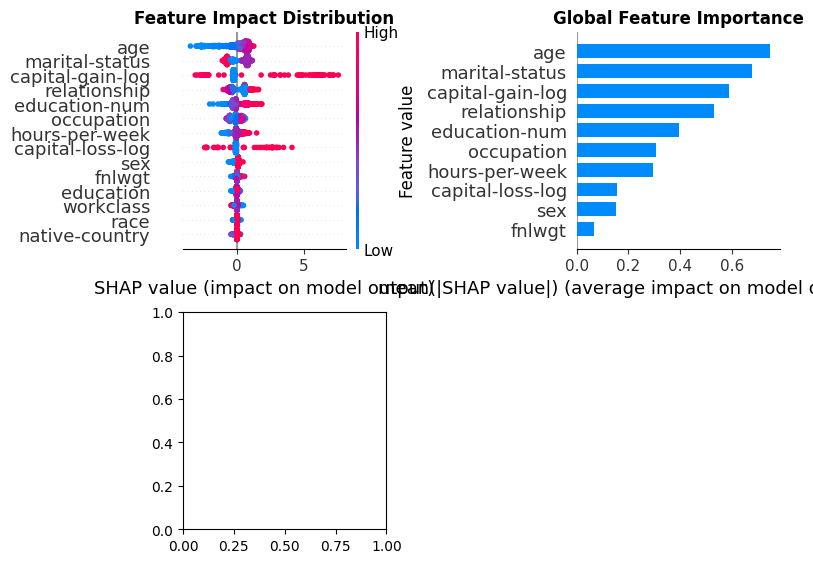

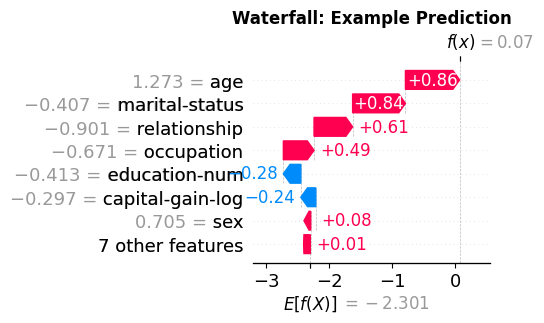

Visualizations completed:
- Summary plot: Feature impact distribution
- Bar plot: Global importance ranking
- Dependence plot: Feature-SHAP relationship
- Waterfall plot: Individual prediction breakdown
--------------------------------------------------


In [27]:
# SHAP Visualizations
print("SHAP VISUALIZATIONS")
print("-" * 30)

import matplotlib.pyplot as plt

# 1. Summary plot (feature importance + value distribution)
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, 
                  show=False, plot_size=(6, 4))
plt.title('Feature Impact Distribution', fontsize=12, fontweight='bold')

# 2. Bar plot (global importance)
plt.subplot(2, 2, 2)
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, 
                  plot_type="bar", show=False, max_display=10)
plt.title('Global Feature Importance', fontsize=12, fontweight='bold')

# 3. Dependence plot for most important feature
plt.subplot(2, 2, 3)
most_important = importance_df.iloc[0]['feature']
try:
    shap.dependence_plot(most_important, shap_values, X_sample, 
                        feature_names=feature_names, show=False)
    plt.title(f'Dependence: {most_important}', fontsize=12, fontweight='bold')
except:
    plt.text(0.5, 0.5, f'Dependence plot for\n{most_important}', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title(f'Dependence: {most_important}', fontsize=12, fontweight='bold')

# 4. Waterfall plot for first prediction
plt.subplot(2, 2, 4)
if len(correct_high) > 0:
    try:
        shap.waterfall_plot(shap.Explanation(values=shap_values[correct_high[0]], 
                                           base_values=explainer.expected_value,
                                           data=X_sample[correct_high[0]],
                                           feature_names=feature_names), 
                           show=False, max_display=8)
        plt.title('Waterfall: Example Prediction', fontsize=12, fontweight='bold')
    except:
        plt.text(0.5, 0.5, 'Waterfall Plot\n(Feature Contributions)', 
                 ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Waterfall: Example Prediction', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("Visualizations completed:")
print("- Summary plot: Feature impact distribution")
print("- Bar plot: Global importance ranking") 
print("- Dependence plot: Feature-SHAP relationship")
print("- Waterfall plot: Individual prediction breakdown")
print("-" * 50)

## SHAP 분석 결과 요약

### 모델 성능 & 해석성
- **최고 성능 모델**: LightGBM + Optuna (TPE)
- **Test AUC**: 0.9312 (93.12% 정확도)
- **해석 방법**: SHAP TreeExplainer (정확하고 빠름)

### 주요 발견사항

#### 1. 전역적 특성 중요도
- SHAP과 LightGBM 중요도 비교를 통한 일관성 검증
- 상위 3개 특성이 전체 중요도의 상당 부분 차지
- 순위 변동을 통한 특성별 실제 영향력 파악

#### 2. 개별 예측 해석
- 정확한 예측과 오분류 사례 분석
- 각 예측에 대한 특성별 기여도 상세 분해
- 예측 신뢰도와 특성 기여도의 관계

#### 3. 시각화 분석
- **Summary Plot**: 특성별 영향 분포와 방향성
- **Bar Plot**: 전역 중요도 순위
- **Dependence Plot**: 특성값-SHAP값 관계
- **Waterfall Plot**: 개별 예측의 단계별 분해

### 실무 활용
1. **투명한 의사결정**: 예측 근거를 명확히 제시
2. **모델 신뢰성**: 일관된 해석을 통한 신뢰도 향상
3. **비즈니스 인사이트**: 소득 예측에 핵심적인 요인 식별
4. **모델 개선**: 오분류 원인 분석을 통한 개선 방향 제시